##### 一、使用的各种库

In [1]:
!pip install torchsummary

import os
import random
import torch
import csv
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchsummary
from PIL import Image

##### 二、处理数据并分为训练集、测试集、验证集
* 设置随机种子使得程序能复现`random_seed=14`
* 设置训练集大小`train_size=0.8`
* 数据集路径需根据位置切换`data_dir`
* 保存数据的路径和相应的标签至各自的数组`train_dir,test_dir,val_dir`
* 保存各个标签所对应的文件名

In [2]:
random_seed=14 #随机种子
train_size=0.8 #训练集大小
random.seed(random_seed)
data_dir = '../input/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'
train_dir,test_dir,val_dir=[],[],[]
data=[]
for i,(filepath,dirnames,filenames) in enumerate(os.walk(data_dir,topdown=False)):
    for y,dirname in enumerate(dirnames):
        data.append({y:dirname})
        print(dirname)
    random.shuffle(filenames)
    length=len(filenames)
    train_length=int(length*train_size)
    val_length=int(length-train_length*0.12)
    for j,filename in enumerate(filenames):
        img_path=os.path.join(filepath,filename)
        if train_length>j:
            train_dir.append((img_path,i))
        elif val_length>j:
            val_dir.append((img_path,i))
        else:
            test_dir.append((img_path,i))
with open('labeldata.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in data:
        writer.writerow([list(row.keys())[0], list(row.values())[0]])


meeting_room
grocerystore
trainstation
mall
bar
auditorium
laboratorywet
florist
closet
livingroom
pantry
airport_inside
prisoncell
locker_room
elevator
dentaloffice
laundromat
fastfood_restaurant
casino
dining_room
kindergarden
concert_hall
waitingroom
bathroom
corridor
bedroom
hairsalon
kitchen
tv_studio
artstudio
library
inside_bus
restaurant_kitchen
inside_subway
buffet
bookstore
museum
lobby
gameroom
shoeshop
garage
poolinside
clothingstore
deli
subway
jewelleryshop
stairscase
toystore
classroom
restaurant
nursery
bakery
bowling
office
operating_room
warehouse
studiomusic
church_inside
computerroom
cloister
greenhouse
winecellar
gym
videostore
hospitalroom
children_room
movietheater


##### 三、自定义Dataset类
> 对图片进行处理

In [3]:
class MyDataset(Dataset):
    def __init__(self,data_list,transform=None):
        self.data_list=data_list
        self.transform=transform

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        img_path,label=self.data_list[index]
        img=Image.open(img_path).convert("RGB")

        if self.transform:
            img=self.transform(img)

        return img,label

##### 四、处理数据
* 每批数据大小`BATCHSIZE=32`
* 缩放图片大小`IMGHIGH,IMGWIDTH=224,224`
* 训练设备初始化`cpu or cuda`
* 定义预处理设置:图像大小缩放，将图像转化为tensor，归一化处理
* 加载数据集并创建DataLoader

In [4]:

BATCHSIZE=32
IMGHIGH,IMGWIDTH=224,224

torch.manual_seed(random_seed)
# 训练设备设置
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
# 定义预处理操作
transform = transforms.Compose([
    transforms.Resize((IMGHIGH,IMGWIDTH)),  # 将图像缩放为224x224大小
    transforms.ToTensor(),  # 将图像转化为tensor
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # 归一化处理
])

# 加载数据集并创建DataLoader
train_dataset=MyDataset(train_dir,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataset=MyDataset(val_dir,transform=transform)
val_loader=DataLoader(val_dataset,batch_size=BATCHSIZE, shuffle=False)
test_dataset=MyDataset(test_dir,transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)
print("训练集大小:",len(train_loader.dataset))
print("验证集大小:",len(val_loader.dataset))
print("测试集大小:",len(test_loader.dataset))

cuda
训练集大小: 12467
验证集大小: 1628
测试集大小: 1525


##### 五、输出图像转化后的图片
* 将图像进行拼接
* 转换为 NumPy 数组并交换通道顺序
* 显示图像

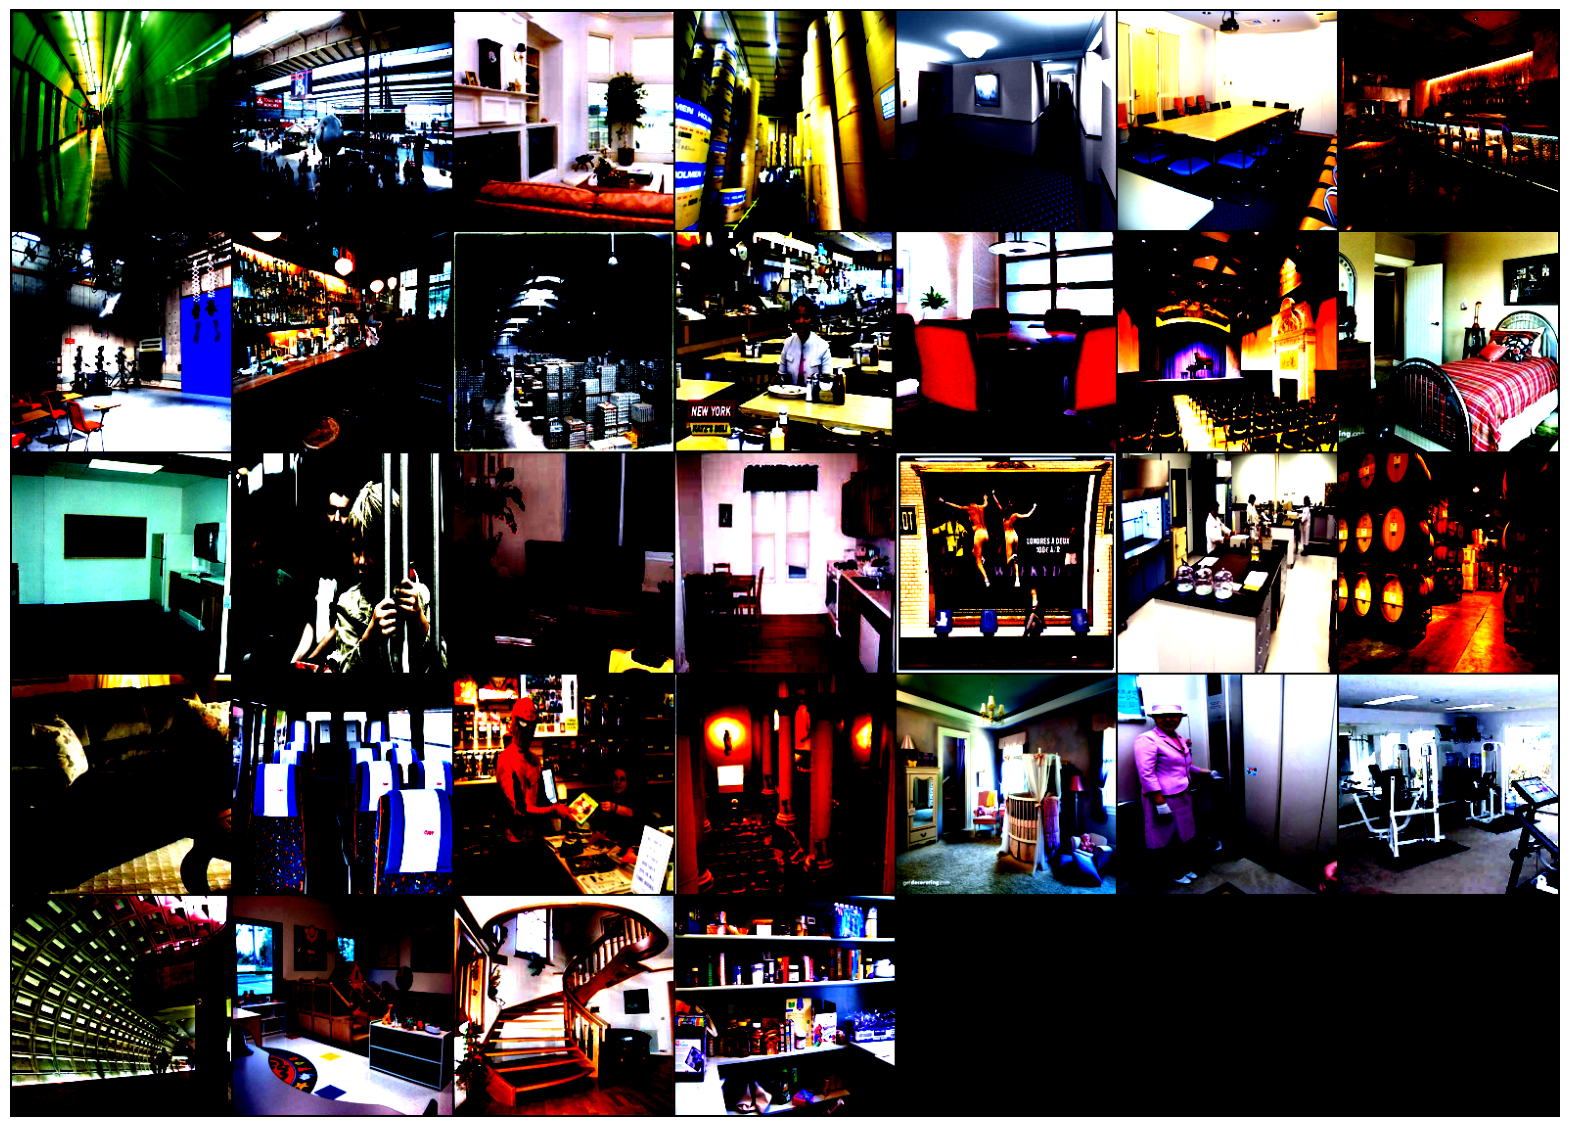

In [5]:
images,labels = next(iter(train_loader))

# 将图像进行拼接
grid_img = torchvision.utils.make_grid(images, nrow=7)

# 转换为 NumPy 数组并交换通道顺序
grid_img = grid_img.numpy().transpose((1, 2, 0))

# 显示图像
plt.figure(figsize=(20,20))
plt.imshow(grid_img)
plt.axis('off')
plt.show()

##### 六、CNN模型

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            # 224x224x3
            nn.Conv2d(3,64,5,2,2),
            nn.MaxPool2d(3,2,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 56x56x64
            nn.Conv2d(64,128,3,2,1),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,5,1,2),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #28*28*128
            nn.Conv2d(128,256,3,2,1),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,5,2,2),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #7*7*256
            nn.AvgPool2d(7),
            nn.Flatten(),
            nn.Linear(256, 67),
        )

    def forward(self, x):
        x = self.conv1(x)
        return x

##### 七、训练、验证和测试函数
训练模式:
> * 需要一开始设置`cnn.train()`
> * 获取数据集大小`size=len(dataloader.dataset)`
> * 获取批数大小计算进度值`batchsize=len(dataloader)`

验证模式(*测试模式*):
> * 将模型设置为评估模式`cnn.eval()`
> * 获取数据集大小`size=len(dataloader.dataset)`
> * 获取批数大小计算进度值`batchsize=len(dataloader)`

In [7]:
def training(dataloader,cnn,loss_function,optimizer):
    cnn.train() #训练模式
    size=len(dataloader.dataset)
    batchsize=len(dataloader)
    train_loss,train_acc=0,0
    for i,(images, labels) in enumerate(dataloader):
        images,labels=images.to(device),labels.to(device)
        output = cnn(images)
        progress = (i+1)/batchsize*100  # 计算当前进度值
        loss=loss_function(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(output.data,1)
        train_loss+=loss.item()*len(labels)
        train_acc+=(predicted==labels).sum().item()
        print("train:{:.2f}%,val:0.00%,test:0.00%".format(progress), end="\r",flush=True)
        
    train_acc/=size
    train_loss/=size
    return train_acc,train_loss
#测试
def testing(dataloader,cnn,loss_function):
    cnn.eval()  # 将模型设置为评估模式
    size=len(dataloader.dataset)
    batchsize=len(dataloader)
    test_loss,test_acc=0,0
    with torch.no_grad():
        for i,(images, labels) in enumerate(dataloader):
            images,labels=images.to(device),labels.to(device)
            progress = (i+1)/batchsize*100  # 计算当前进度值
            output = cnn(images)
            _,predicted=torch.max(output.data,1)
            test_loss += loss_function(output, labels).item()*len(labels)
            test_acc += (predicted==labels).sum().item()
            print("train:100.00%,val:100.00%,test:{:.2f}%".format(progress), end="\r",flush=True)

        test_acc /= size
        test_loss /= size
        return test_acc,test_loss
#验证模型
def validate(dataloader,cnn,loss_function):
    cnn.eval()  # 将模型设置为评估模式
    size=len(dataloader.dataset)
    batchsize=len(dataloader)
    val_acc,val_loss=0,0
    with torch.no_grad():
        for i,(images, labels) in enumerate(dataloader):
            progress = (i+1)/batchsize*100  # 计算当前进度值
            images,labels=images.to(device),labels.to(device)
            output = cnn(images)
            _,predicted=torch.max(output.data,1)
            val_loss += loss_function(output, labels).item()*len(labels)
            val_acc += (predicted==labels).sum().item()
            print("train:100.00%,val:{:.2f}%,test:0.00%".format(progress), end="\r",flush=True)

        val_acc /= size
        val_loss /= size
        return val_acc,val_loss
    

##### 八、进行训练迭代和超参数改变
* 迭代次数`CYCLE`
* 学习率`LEARNRATE`
* 保存正确率和损失率
* 显示模型结构`torchsummary.summary(cnn, (3, IMGHIGH, IMGWIDTH), batch_size=BATCHSIZE)`
* 保存最好的模型`torch.save(cnn.state_dict(),'best_model.pt')`

In [48]:
CYCLE=20
LEARNRATE=1e-3
acc_train,acc_val,acc_test=[],[],[]
train_losses,val_losses,test_losses=[],[],[]
if __name__ == '__main__':
    cnn = CNN().to(device)
    print(cnn)
    torchsummary.summary(cnn, (3, IMGHIGH, IMGWIDTH), batch_size=BATCHSIZE)
    optimizer = optim.Adam(cnn.parameters(), lr=LEARNRATE)
    loss_function = nn.CrossEntropyLoss()
    best_acc=0.0
    for epoch in range(CYCLE):
        train_acc,train_loss=training(train_loader,cnn,loss_function,optimizer)
        val_acc,val_loss=validate(val_loader,cnn,loss_function)
        test_acc,test_loss=testing(test_loader,cnn,loss_function)
        temp='\repoch:{},train_acc:{:.2f}%,train_loss:{:.3f},val_acc:{:.2f}%,val_loss:{:.3f},test_acc:{:.2f}%,test_loss:{:.3f}'
        print(temp.format(epoch+1,train_acc*100,train_loss,val_acc*100,val_loss,test_acc*100,test_loss)) 
        acc_train.append(train_acc)
        acc_val.append(val_acc)
        acc_test.append(test_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        if val_acc>best_acc:
            torch.save(cnn.state_dict(),'best_model.pt')

    print("ok!")   

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (14): Batc

##### 九、训练、验证和测试数据的损失率

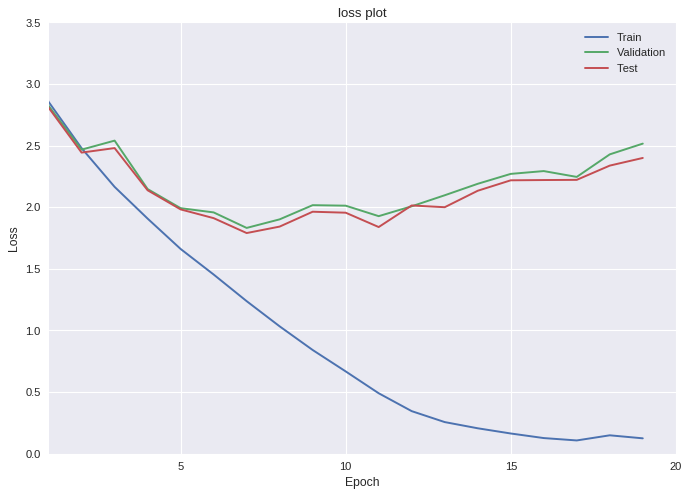

In [49]:
plt.style.use('seaborn-v0_8')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses,label='Test')

# 设置 x 轴和 y 轴标签
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 设置标题
plt.title('loss plot')
# 设置图例
plt.legend()
plt.xlim([1,20])
plt.ylim([0,3.5])

# 显示图形
plt.show()

##### 十、绘制准确率曲线

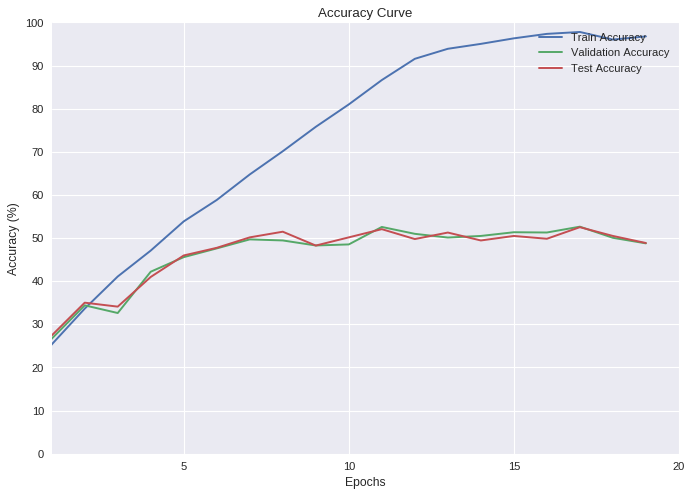

In [51]:
plt.style.use('seaborn-v0_8')#设置plt显示样式
plt.plot([x*100 for x in acc_train], label='Train Accuracy')
plt.plot([x*100 for x in acc_val], label='Validation Accuracy')
plt.plot([x*100 for x in acc_test],label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')  # 修改y轴标签为百分比形式
plt.title('Accuracy Curve')
plt.legend()
plt.xlim([1,20])
plt.ylim([0,100])
# 设置y轴的刻度位置
plt.yticks([0,10, 20, 30,40,50, 60,70, 80,90,100])

plt.show()